<a href="https://colab.research.google.com/github/Zhalil24/BreastMRI-CNN-Classification/blob/main/DenseNet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Cihaz Ayarı (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan Cihaz: {device}")

Kullanılan Cihaz: cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

!cp "/content/drive/MyDrive/data_set_zip/breast_mri_dataset.rar" /content/
!unrar x /content/breast_mri_dataset.rar /content/

Görüntülenen çıkış son 5000 satıra kısaltıldı.
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8061.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8253.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8422.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8489.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8575.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8605.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8659.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8680.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8693.jpg      78%  OK 
Extracti

In [4]:
# 2. Veri Dönüşümleri (Data Augmentation)
mri_mean = [0.485, 0.456, 0.406]
mri_std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mri_mean, mri_std)
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mri_mean, mri_std)
])

In [5]:
# 3. Veri Yükleyicileri Hazırlama
data_dir = '/content/breast_mri_dataset'

def get_dataset(root, transform):
    return datasets.ImageFolder(os.path.join(data_dir, root), transform=transform)
full_train_dataset = get_dataset('train', train_transforms)
val_dataset = get_dataset('val', val_test_transforms)
test_dataset = get_dataset('test', val_test_transforms)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
# 4. Model Oluşturma ve Katman Stratejisi
def build_model():
    model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
    for param in model.parameters():
        param.requires_grad = False
    for param in model.features.denseblock2.parameters(): param.requires_grad = True
    for param in model.features.denseblock3.parameters(): param.requires_grad = True
    for param in model.features.denseblock4.parameters(): param.requires_grad = True

    num_ftrs = model.classifier.in_features
    model.classifier = nn.Sequential(
        nn.Linear(num_ftrs, 2) # Binary: Benign, Malignant
    )

    return model.to(device)

In [7]:
# 5. Diferansiyel Öğrenme Oranı Ayarı
def get_optimizer(model):
    optimizer = optim.Adam([
        {'params': model.features.denseblock2.parameters(), 'lr': 1e-5},
        {'params': model.features.denseblock3.parameters(), 'lr': 5e-5},
        {'params': model.features.denseblock4.parameters(), 'lr': 1e-4},
        {'params': model.classifier.parameters(), 'lr': 1e-3}
    ])
    return optimizer

criterion = nn.CrossEntropyLoss()

In [8]:
# 6. Eğitim Fonksiyonu
def train_one_epoch(model, loader, optimizer):
    model.train()
    running_loss, correct = 0.0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
    return running_loss / len(loader.dataset), correct / len(loader.dataset)

def validate(model, loader):
    model.eval()
    running_loss, correct = 0.0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
    return running_loss / len(loader.dataset), correct / len(loader.dataset)

In [9]:
# 7. 5-Fold Stratified Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_indices = np.arange(len(full_train_dataset))
train_labels = full_train_dataset.targets

fold_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(train_indices, train_labels)):
    print(f"\n--- FOLD {fold+1}/5 ---")

    train_sub = Subset(full_train_dataset, train_idx)
    train_loader = DataLoader(train_sub, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    model = build_model()
    optimizer = get_optimizer(model)

    epochs = 10
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        t_loss, t_acc = train_one_epoch(model, train_loader, optimizer)
        v_loss, v_acc = validate(model, val_loader)

        history['train_loss'].append(t_loss)
        history['train_acc'].append(t_acc)
        history['val_loss'].append(v_loss)
        history['val_acc'].append(v_acc)

        print(f"Epoch {epoch+1}: T_Loss: {t_loss:.4f} | T_Acc: {t_acc:.4f} | V_Loss: {v_loss:.4f} | V_Acc: {v_acc:.4f}")

    fold_results.append(history)
    if fold == 0:
        final_model = model


--- FOLD 1/5 ---
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 236MB/s]


Epoch 1: T_Loss: 0.4387 | T_Acc: 0.7750 | V_Loss: 0.2305 | V_Acc: 0.8951
Epoch 2: T_Loss: 0.2548 | T_Acc: 0.8814 | V_Loss: 0.1352 | V_Acc: 0.9427
Epoch 3: T_Loss: 0.1681 | T_Acc: 0.9281 | V_Loss: 0.0979 | V_Acc: 0.9627
Epoch 4: T_Loss: 0.1389 | T_Acc: 0.9403 | V_Loss: 0.0728 | V_Acc: 0.9669
Epoch 5: T_Loss: 0.1130 | T_Acc: 0.9522 | V_Loss: 0.0873 | V_Acc: 0.9636
Epoch 6: T_Loss: 0.0968 | T_Acc: 0.9599 | V_Loss: 0.0550 | V_Acc: 0.9777
Epoch 7: T_Loss: 0.0799 | T_Acc: 0.9685 | V_Loss: 0.0505 | V_Acc: 0.9777
Epoch 8: T_Loss: 0.0784 | T_Acc: 0.9687 | V_Loss: 0.0440 | V_Acc: 0.9825
Epoch 9: T_Loss: 0.0701 | T_Acc: 0.9738 | V_Loss: 0.0474 | V_Acc: 0.9827
Epoch 10: T_Loss: 0.0616 | T_Acc: 0.9762 | V_Loss: 0.0521 | V_Acc: 0.9791

--- FOLD 2/5 ---
Epoch 1: T_Loss: 0.4438 | T_Acc: 0.7719 | V_Loss: 0.3155 | V_Acc: 0.8514
Epoch 2: T_Loss: 0.2456 | T_Acc: 0.8909 | V_Loss: 0.1664 | V_Acc: 0.9318
Epoch 3: T_Loss: 0.1798 | T_Acc: 0.9253 | V_Loss: 0.1310 | V_Acc: 0.9446
Epoch 4: T_Loss: 0.1369 | T_Acc:

In [10]:
# 8. Performans Metrikleri ve Test Değerlendirmesi
def evaluate_test(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    print("\n--- TEST SETİ PERFORMANSI ---")
    print(f"Accuracy:  {accuracy_score(all_labels, all_preds):.4f}")
    print(f"Precision: {precision_score(all_labels, all_preds):.4f}")
    print(f"Recall:    {recall_score(all_labels, all_preds):.4f}")
    print(f"F1-Score:  {f1_score(all_labels, all_preds):.4f}")
    print(f"ROC-AUC:   {roc_auc_score(all_labels, all_probs):.4f}")

    return all_labels, all_preds, all_probs

test_labels, test_preds, test_probs = evaluate_test(final_model, test_loader)


--- TEST SETİ PERFORMANSI ---
Accuracy:  0.9778
Precision: 0.9954
Recall:    0.9600
F1-Score:  0.9774
ROC-AUC:   0.9991


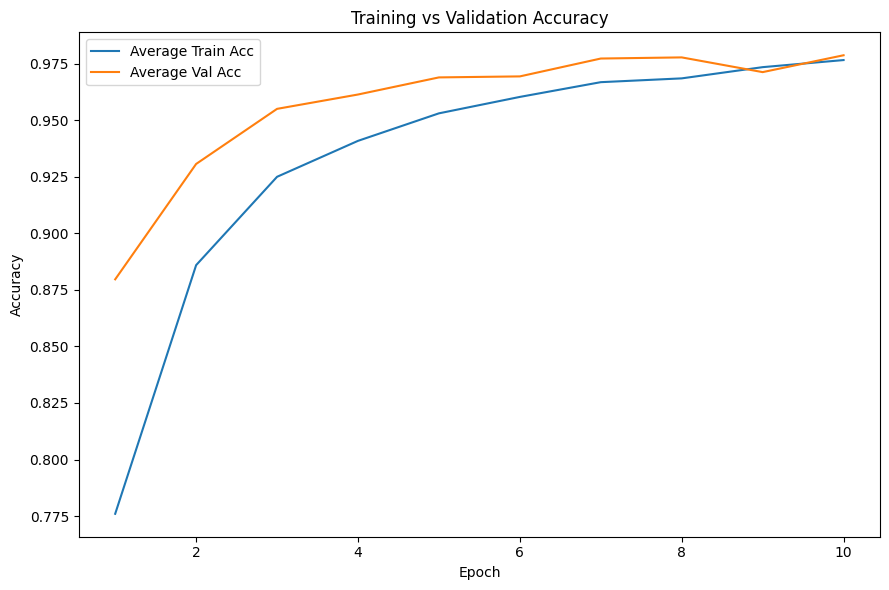

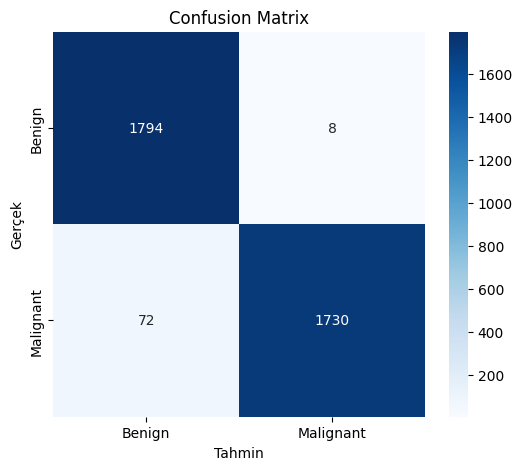

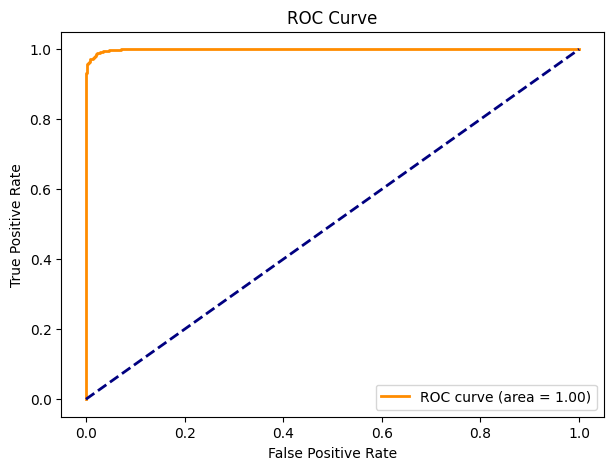

In [11]:
# 9. Görselleştirme
all_train_acc = np.array([history['train_acc'] for history in fold_results])
all_val_acc = np.array([history['val_acc'] for history in fold_results])

mean_train_acc = np.mean(all_train_acc, axis=0)
mean_val_acc = np.mean(all_val_acc, axis=0)

epochs = range(1, len(mean_train_acc) + 1)

# Plot 1: Accuracy Grafiği (Tüm foldların ortalaması)
plt.figure(figsize=(9, 6))
plt.plot(epochs, mean_train_acc, label='Average Train Acc')
plt.plot(epochs, mean_val_acc, label='Average Val Acc')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# B. Confusion Matrix (Mevcut kodun devam edebilir)
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix')
plt.ylabel('Gerçek')
plt.xlabel('Tahmin')
plt.show()

# C. ROC Curve (Mevcut kodun devam edebilir)
fpr, tpr, _ = roc_curve(test_labels, test_probs)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_score(test_labels, test_probs):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()